
# Import

In [31]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import re
from skimage.feature import hog
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import mnist_reader
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.colors as mcolors

# Get Images and Labels 

In [32]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [33]:
print(X_train.shape)

(60000, 784)


In [34]:
# global variables
pca_percentage = 0.95
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# 4.1 Feature Extraction: HOG and PCA

## 4.1.1 HOG

In [35]:
def extract_hog_features(X):
    hog_features = []
    for image in X:
        feature = hog(image.reshape(28, 28),
                      pixels_per_cell=(4, 4), 
                      cells_per_block=(2, 2), 
                      orientations=9, 
                      block_norm='L2-Hys')
        hog_features.append(feature)
    return np.array(hog_features)

In [36]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

X_train_hog[0].reshape(1,-1).shape

(1, 1296)

## 4.1.2 PCA

In [37]:
pca = PCA(pca_percentage)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [38]:
print("Cumulative Variance Explained by PCA", np.sum(pca.explained_variance_ratio_))

Cumulative Variance Explained by PCA 0.9500039103537352


## 4.1.3 Size Comparison

In [39]:
print("X_train_hog:", X_train_hog.shape)
print("X_test_hog:", X_test_hog.shape)
print("X_train_pca:", X_train_pca.shape)
print("X_test_pca:", X_test_pca.shape)

X_train_hog: (60000, 1296)
X_test_hog: (10000, 1296)
X_train_pca: (60000, 187)
X_test_pca: (10000, 187)


# 4.2 Viewing the Extracted Attributes

## 4.2.1 Class Balance Analysis

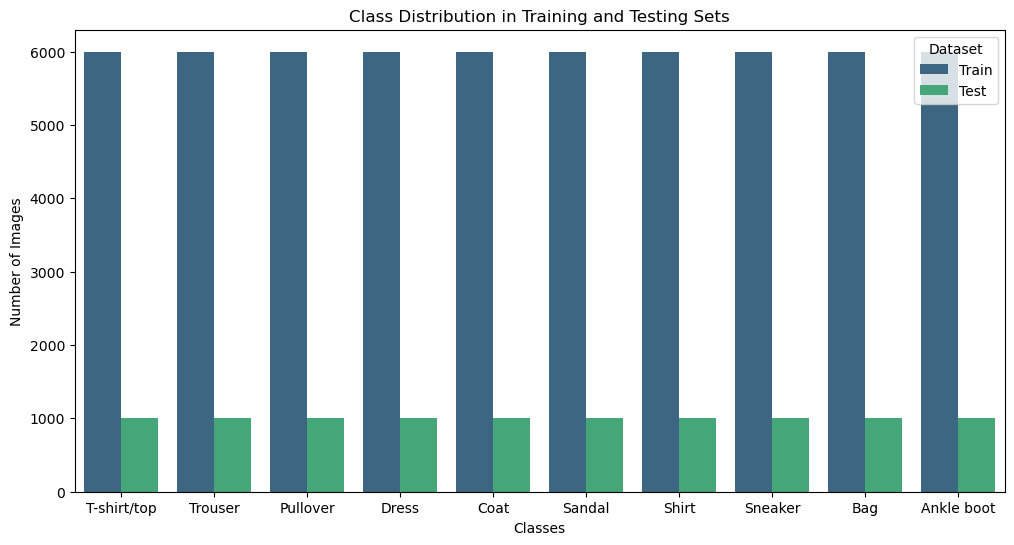

In [40]:
train_df = pd.DataFrame({'Label': y_train, 'Dataset': 'Train'})
test_df = pd.DataFrame({'Label': y_test, 'Dataset': 'Test'})
combined_df = pd.concat([train_df, test_df])

plt.figure(figsize=(12, 6))
sns.countplot(data=combined_df, x='Label', hue='Dataset', palette='viridis')
plt.title("Class Distribution in Training and Testing Sets")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(ticks=range(10), labels=class_names)
plt.legend(title='Dataset')
plt.show()


## 4.2.2. Quantitative / Qualitative Visualization of the Attribute Extraction Effect

### A) Quantitative Visualizations

#### A.1 Quantitative PCA Visualization: The Degree of Cumulative Variance Explained by the Selected Number of Principal Components

Number of Selected Principal Components: 187


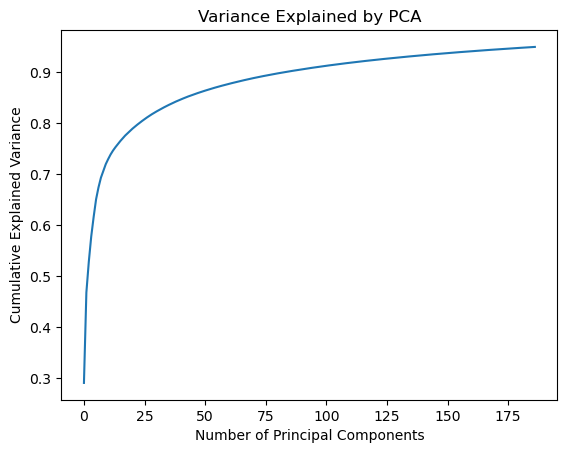

In [41]:
print("Number of Selected Principal Components:", X_train_pca.shape[1])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by PCA')
plt.show()

#### A.2 Quantitative HOG Visualization: Histogram of HOG Feature Magnitudes

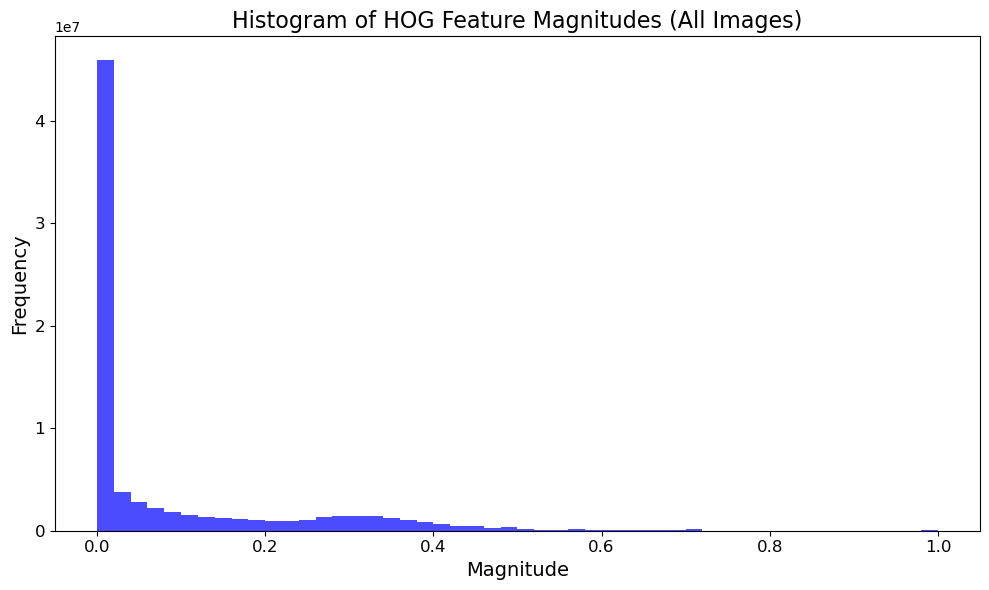

In [85]:
all_fd = np.concatenate([X_train_hog[i].flatten() for i in range(X_train_hog.shape[0])])

plt.figure(figsize=(10, 6))
plt.hist(all_fd, bins=50, color='b', alpha=0.7)
plt.title('Histogram of HOG Feature Magnitudes (All Images)', fontsize=16)
plt.xlabel('Magnitude', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



### B) Qualitative Visualization

#### B.1 For the PCA method, Visualization of Reconstructed Images Using the Selected Principal Components

In [42]:
def display_pca_reconstructed_images_per_class(X, y, class_names, percentage_variance):
    pca = PCA(percentage_variance)
    X_train_pca = pca.fit_transform(X)
    X_train_reconstructed = pca.inverse_transform(X_train_pca)

    displayed_classes = {}

    for index, (image, label) in enumerate(zip(X, y)):
        if label not in displayed_classes:
            displayed_classes[label] = index

        if len(displayed_classes) == len(class_names):
            break

    fig, axes = plt.subplots(2, len(class_names), figsize=(15, 5))
    n_components = pca.n_components_
    print(f"Number of components to retain {percentage_variance} variance: {n_components}")
    
    fig.suptitle(f"PCA Reconstruction with {n_components} Components", fontsize=16)

    for class_label, class_index in displayed_classes.items():
        original_image = X[class_index].reshape(28, 28)
        reconstructed_image = X_train_reconstructed[class_index].reshape(28, 28)

        axes[0, class_label].imshow(original_image, cmap='gray')
        axes[0, class_label].set_title(class_names[class_label])
        axes[0, class_label].axis('off')

        axes[1, class_label].imshow(reconstructed_image, cmap='gray')
        axes[1, class_label].axis('off')

    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstructed", fontsize=12)

    plt.show()

Number of components to retain 0.95 variance: 187


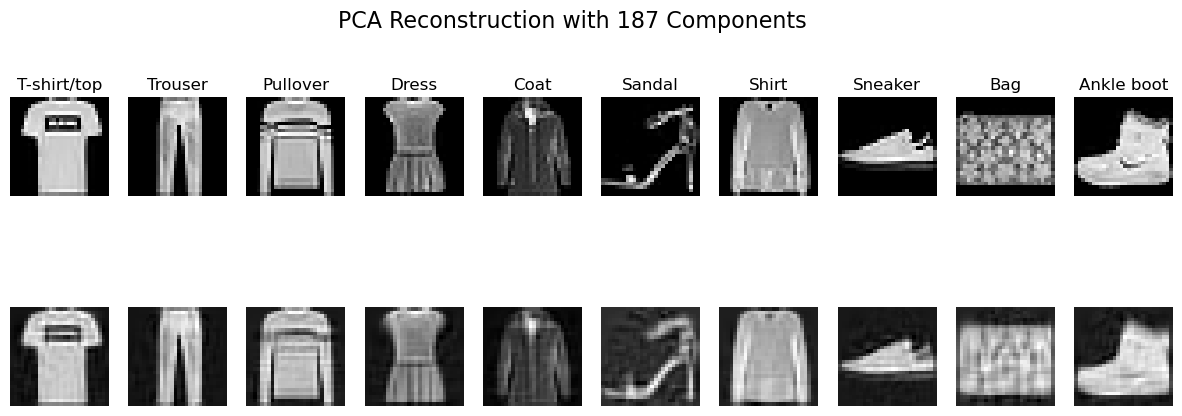

In [43]:
display_pca_reconstructed_images_per_class(X_train, y_train, class_names, pca_percentage)

#### B.2 For the HOG method

In [44]:
def display_hog_images(X, y, class_names):
    displayed_classes = set()
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    
    for i, (image, label) in enumerate(zip(X, y)):
        if label not in displayed_classes:
            displayed_classes.add(label)
            reshape_image = image.reshape(28, 28)
            hog_features, hog_image = hog(reshape_image,
                                          pixels_per_cell=(4, 4), 
                                          cells_per_block=(2, 2), 
                                          orientations=9, 
                                          block_norm='L2-Hys', 
                                          visualize=True)
            
            axes[label].imshow(hog_image, cmap='gray')
            axes[label].set_title(class_names[label])
            axes[label].axis('off')
        
        if len(displayed_classes) == 10:
            break
            
    plt.suptitle("HOG Visualizations for Each Class")
    plt.show()

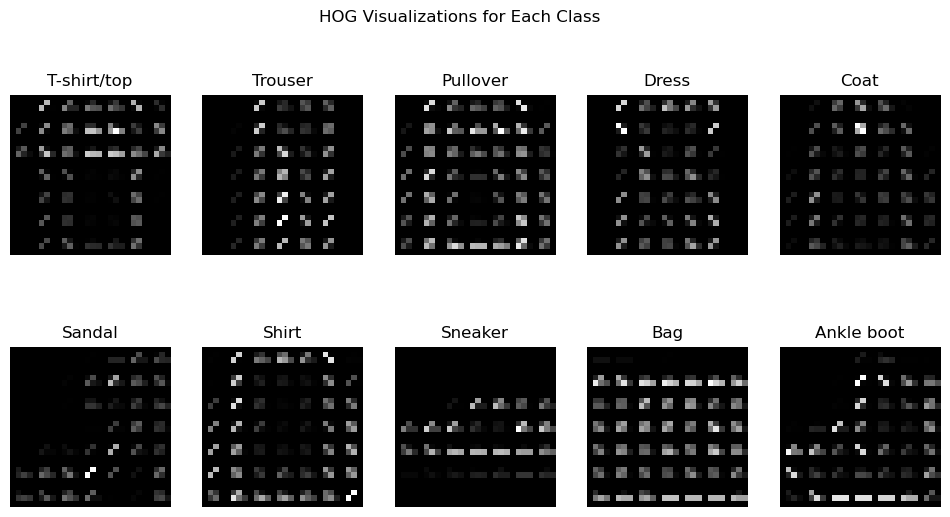

In [45]:
display_hog_images(X_train, y_train, class_names)

# 4.3. Standardization and Attribute Selection


## 4.3.1 Feature Combination

In [46]:
X_train_combined = np.hstack([X_train_hog, X_train_pca])
X_test_combined = np.hstack([X_test_hog, X_test_pca])

## 4.3.2 Standardization

In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

## 4.3.3 Attribute Selection

In [48]:
selector = SelectPercentile(score_func=f_classif, percentile=50)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

## 4.3.4 Size Comparison

In [49]:
print("X_train:", X_train.shape)
print("X_train_pca:", X_train_pca.shape)
print("X_train_hog:", X_train_hog.shape)
print("X_train_combined:", X_train_combined.shape)
print("X_train_scaled:", X_train_scaled.shape)
print("X_train_selected:", X_train_selected.shape)


X_train: (60000, 784)
X_train_pca: (60000, 187)
X_train_hog: (60000, 1296)
X_train_combined: (60000, 1483)
X_train_scaled: (60000, 1483)
X_train_selected: (60000, 741)


# 4.4. Machine Learning Algorithms

## 4.4.1 Logistic Regression

In [50]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train_selected, y_train, test_size=0.2, random_state=42
)

In [51]:
print(f"Training Set Size: {X_train_small.shape}")
print(f"Validation Set Size: {X_val.shape}")

Training Set Size: (48000, 741)
Validation Set Size: (12000, 741)


In [52]:
log_reg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.1, 1, 10],               
    'penalty': ['l2'],               
    'multi_class': ['ovr', 'multinomial'],         
    'solver': ['lbfgs']           
}

grid_search_log = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, scoring='accuracy',  verbose=1, n_jobs=-1)


In [53]:
grid_search_log.fit(X_train_small, y_train_small)

print("Best Parameters:", grid_search_log.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}


In [54]:
best_model_log = grid_search_log.best_estimator_

In [55]:
y_pred_val_log = best_model_log.predict(X_val)
accuracy_val_log = accuracy_score(y_val, y_pred_val_log)
print(f"Accuracy on the Validation Set: {accuracy_val_log}")

Accuracy on the Validation Set: 0.8874166666666666


In [56]:
y_pred_test_log = best_model_log.predict(X_test_selected) 
accuracy_test_log = accuracy_score(y_test, y_pred_test_log)

print(f"Accuracy on the Test Set: {accuracy_test_log}")

Accuracy on the Test Set: 0.8816


### Table Report for Logistic Regression

In [57]:
print("Test Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_test_log, target_names=class_names))

Test Classification Report for Logistic Regression:
               precision    recall  f1-score   support

 T-shirt/top       0.83      0.84      0.84      1000
     Trouser       0.97      0.97      0.97      1000
    Pullover       0.82      0.81      0.82      1000
       Dress       0.87      0.87      0.87      1000
        Coat       0.78      0.84      0.81      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.69      0.63      0.66      1000
     Sneaker       0.93      0.96      0.95      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Confusion Matrix for Logistic Regression

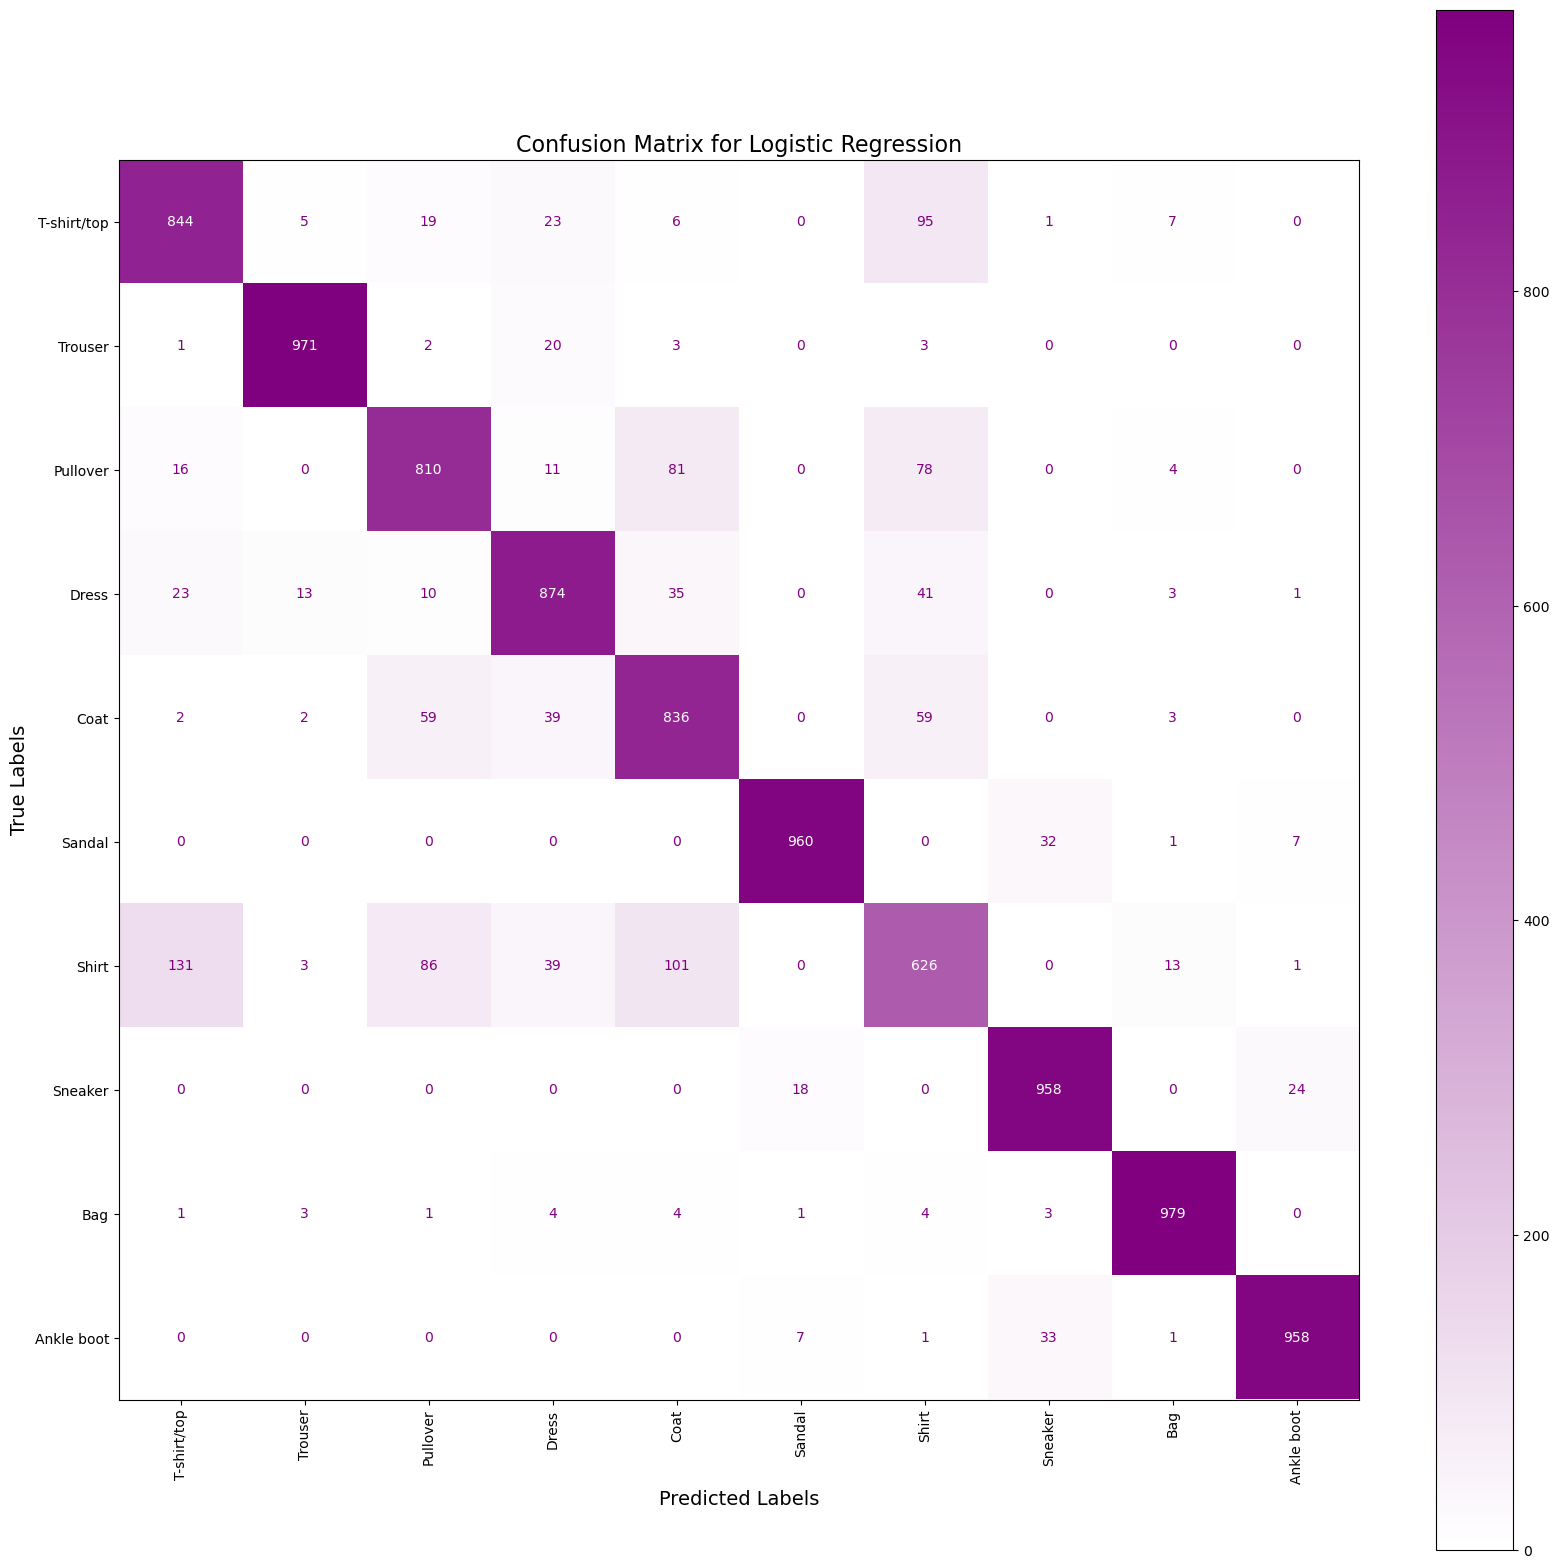

In [58]:
conf_matrix_xgb = confusion_matrix(y_test, y_pred_test_log)

white_to_pink = mcolors.LinearSegmentedColormap.from_list("white_to_pink", ["white", "purple"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=class_names)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=white_to_pink, ax=ax, xticks_rotation='vertical')

plt.title("Confusion Matrix for Logistic Regression", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.show()


## 4.4.2 SVM

In [59]:
svm = SVC()

param_grid_svm = {
    'C': [0.1, 1, 10],                  
    'kernel': ['linear', 'rbf', 'poly']  
}

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)


In [60]:
grid_search_svm.fit(X_train_small, y_train_small)
print("Best parameters for SVM:", grid_search_svm.best_params_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ...............................C=0.1, kernel=linear; total time= 4.9min


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ...............................C=0.1, kernel=linear; total time= 4.9min
[CV] END ...............................C=0.1, kernel=linear; total time= 5.0min
[CV] END .................................C=1, kernel=linear; total time= 7.0min
[CV] END .................................C=1, kernel=linear; total time= 7.2min
[CV] END .................................C=1, kernel=linear; total time= 7.5min
[CV] END ..................................C=0.1, kernel=rbf; total time=11.3min
[CV] END ..................................C=0.1, kernel=rbf; total time=11.3min
[CV] END ..................................C=0.1, kernel=rbf; total time=11.4min
[CV] END ....................................C=1, kernel=rbf; total time= 8.2min
[CV] END ....................................C=1, kernel=rbf; total time= 8.2min
[CV] END ....................................C=1, kernel=rbf; total time= 8.5min
[CV] END .................................C=0.1, kernel=poly; total time=13.9min
[CV] END ...................

In [61]:
best_model_svm = grid_search_svm.best_estimator_

In [62]:
y_pred_val_svm = best_model_svm.predict(X_val)
accuracy_val_svm = accuracy_score(y_val, y_pred_val_svm)

print(f"Accuracy on the Validation Set: {accuracy_val_svm}")

Accuracy on the Validation Set: 0.9096666666666666


In [63]:
y_pred_test_svm = best_model_svm.predict(X_test_selected)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

In [64]:
print(f"Accuracy on the Test Set: {accuracy_test_svm}")

Accuracy on the Test Set: 0.9076


### Table Report for SVM

In [65]:
print("Test Classification Report for SVM:\n", classification_report(y_test, y_pred_test_svm, target_names=class_names))

Test Classification Report for SVM:
               precision    recall  f1-score   support

 T-shirt/top       0.86      0.86      0.86      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.85      0.85      0.85      1000
       Dress       0.89      0.92      0.90      1000
        Coat       0.85      0.86      0.85      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.75      0.73      0.74      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



### Confusion Matrix for SVM

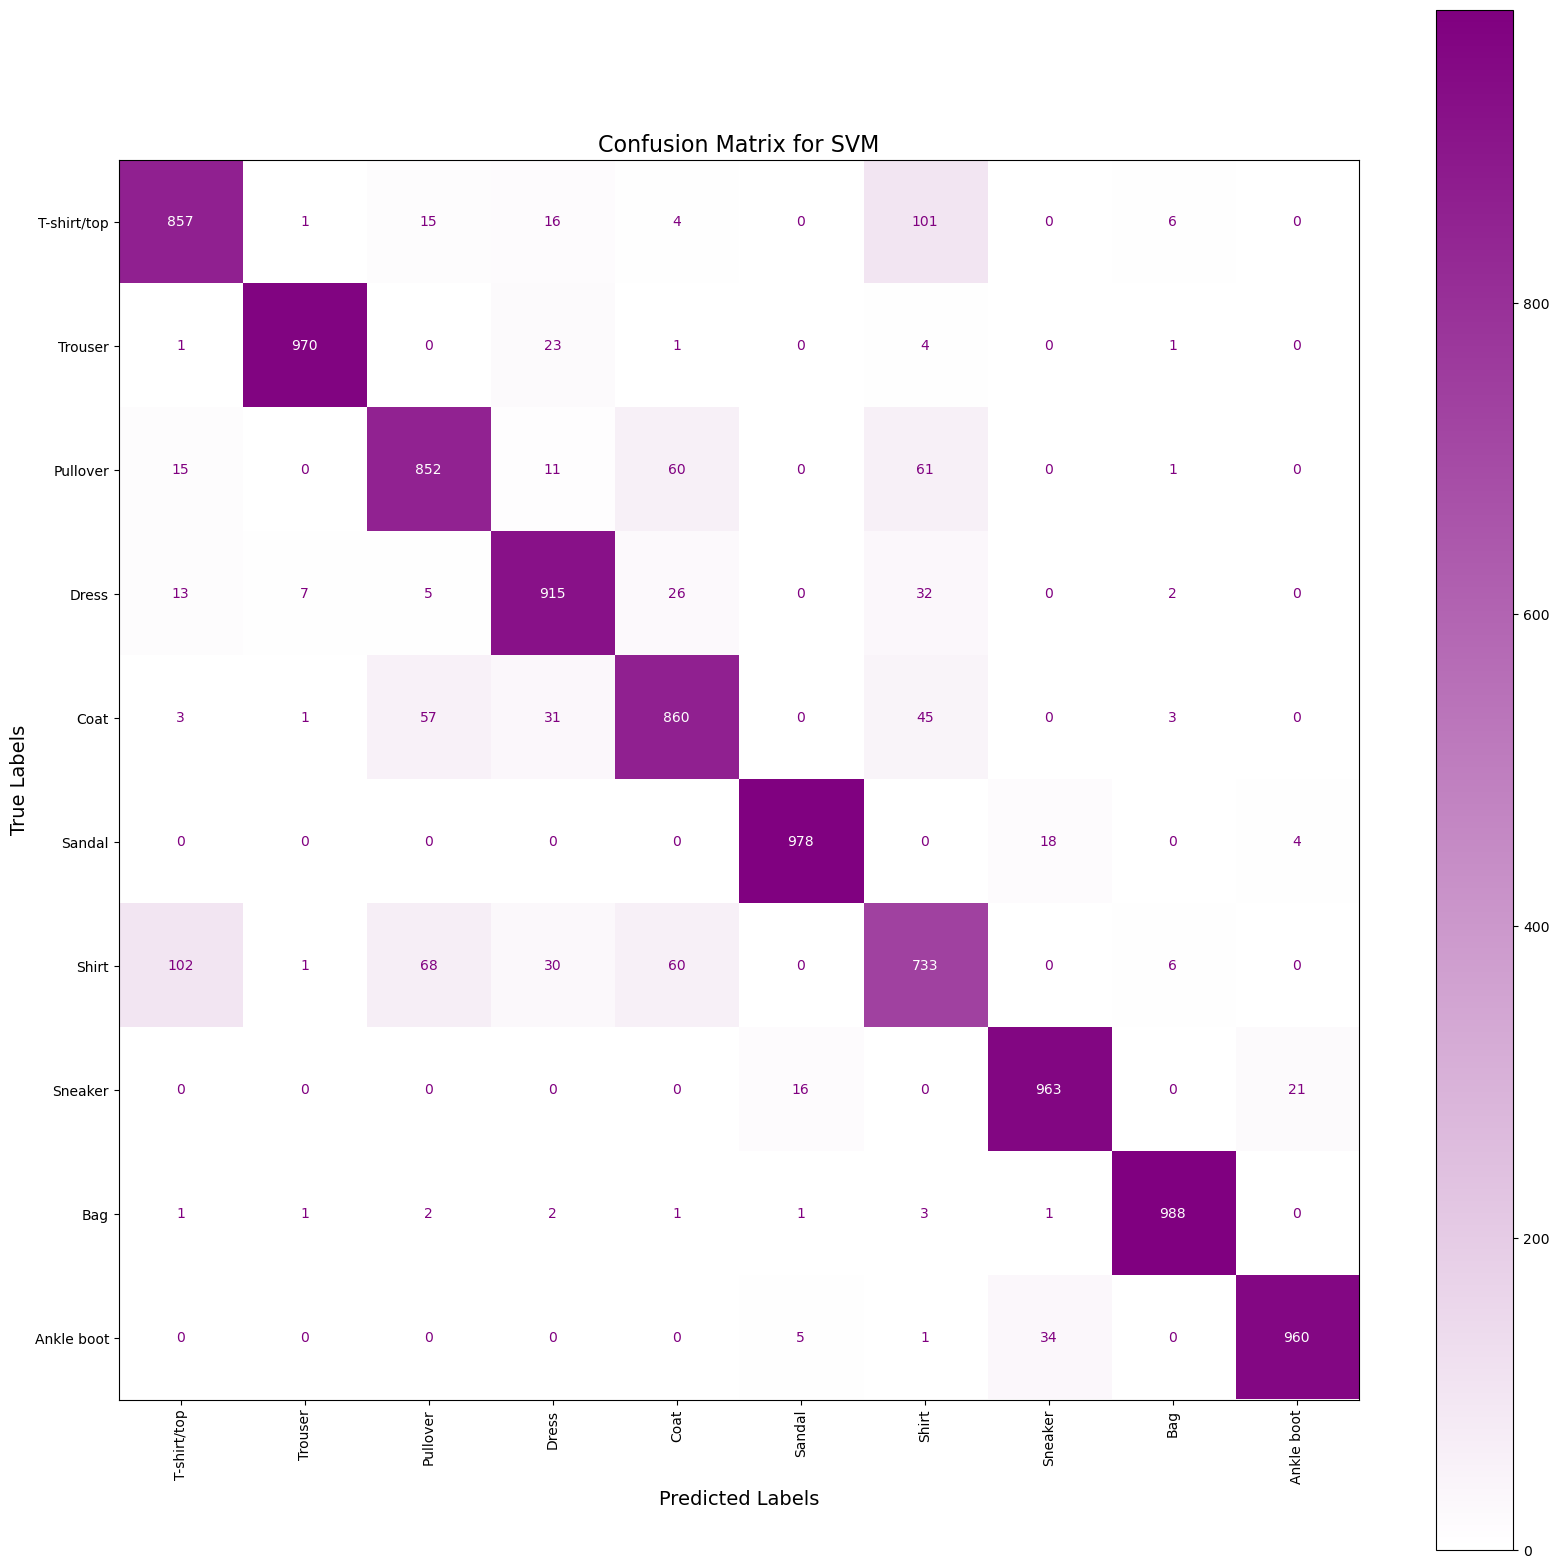

In [66]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_test_svm)

white_to_pink = mcolors.LinearSegmentedColormap.from_list("white_to_pink", ["white", "purple"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=white_to_pink, ax=ax, xticks_rotation='vertical')

plt.title("Confusion Matrix for SVM", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.show()


## 4.4.3. RandomForest 

In [84]:
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20],
    'max_samples': [0.6, 0.8, 1.0]
}

grid_search_rf = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid_rf, 
    cv=3, 
    scoring='accuracy', 
    verbose=2, 
    n_jobs=-1
)

In [68]:
grid_search_rf.fit(X_train_small, y_train_small)

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .....max_depth=10, max_samples=0.6, n_estimators=50; total time=  14.0s
[CV] END .....max_depth=10, max_samples=0.6, n_estimators=50; total time=  14.1s
[CV] END .....max_depth=10, max_samples=0.6, n_estimators=50; total time=  14.2s
[CV] END .....max_depth=10, max_samples=0.8, n_estimators=50; total time=  17.5s
[CV] END .....max_depth=10, max_samples=0.8, n_estimators=50; total time=  17.6s
[CV] END .....max_depth=10, max_samples=0.8, n_estimators=50; total time=  17.6s
[CV] END ....max_depth=10, max_samples=0.6, n_estimators=100; total time=  28.6s
[CV] END ....max_depth=10, max_samples=0.6, n_estimators=100; total time=  28.8s
[CV] END ....max_depth=10, max_samples=0.6, n_estimators=100; total time=  29.0s
[CV] END .....max_depth=10, max_samples=1.0, n_estimators=50; total time=  20.2s
[CV] END .....max_depth=10, max_samples=1.0, n_estimators=50; total time=  20.6s
[CV] END .....max_depth=10, max_samples=1.0, n_e

In [69]:
best_model_rf = grid_search_rf.best_estimator_

In [70]:
y_pred_val_rf = best_model_rf.predict(X_val)
accuracy_val_rf = accuracy_score(y_val, y_pred_val_rf)
print(f"Accuracy on the Validation Set: {accuracy_val_rf}")

Accuracy on the Validation Set: 0.8731666666666666


In [71]:
y_pred_test_rf = best_model_rf.predict(X_test_selected)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
print(f"Accuracy on the Test Set: {accuracy_test_rf}")

Accuracy on the Test Set: 0.873


### Table Report for RandomForest

In [72]:
print("Test Classification Report for RandomForest:\n", classification_report(y_test, y_pred_test_rf, target_names=class_names))

Test Classification Report for RandomForest:
               precision    recall  f1-score   support

 T-shirt/top       0.82      0.85      0.84      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.82      0.82      0.82      1000
       Dress       0.85      0.88      0.87      1000
        Coat       0.79      0.83      0.81      1000
      Sandal       0.96      0.94      0.95      1000
       Shirt       0.68      0.60      0.64      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.95      0.97      0.96      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### Confusion Matrix for RandomForest

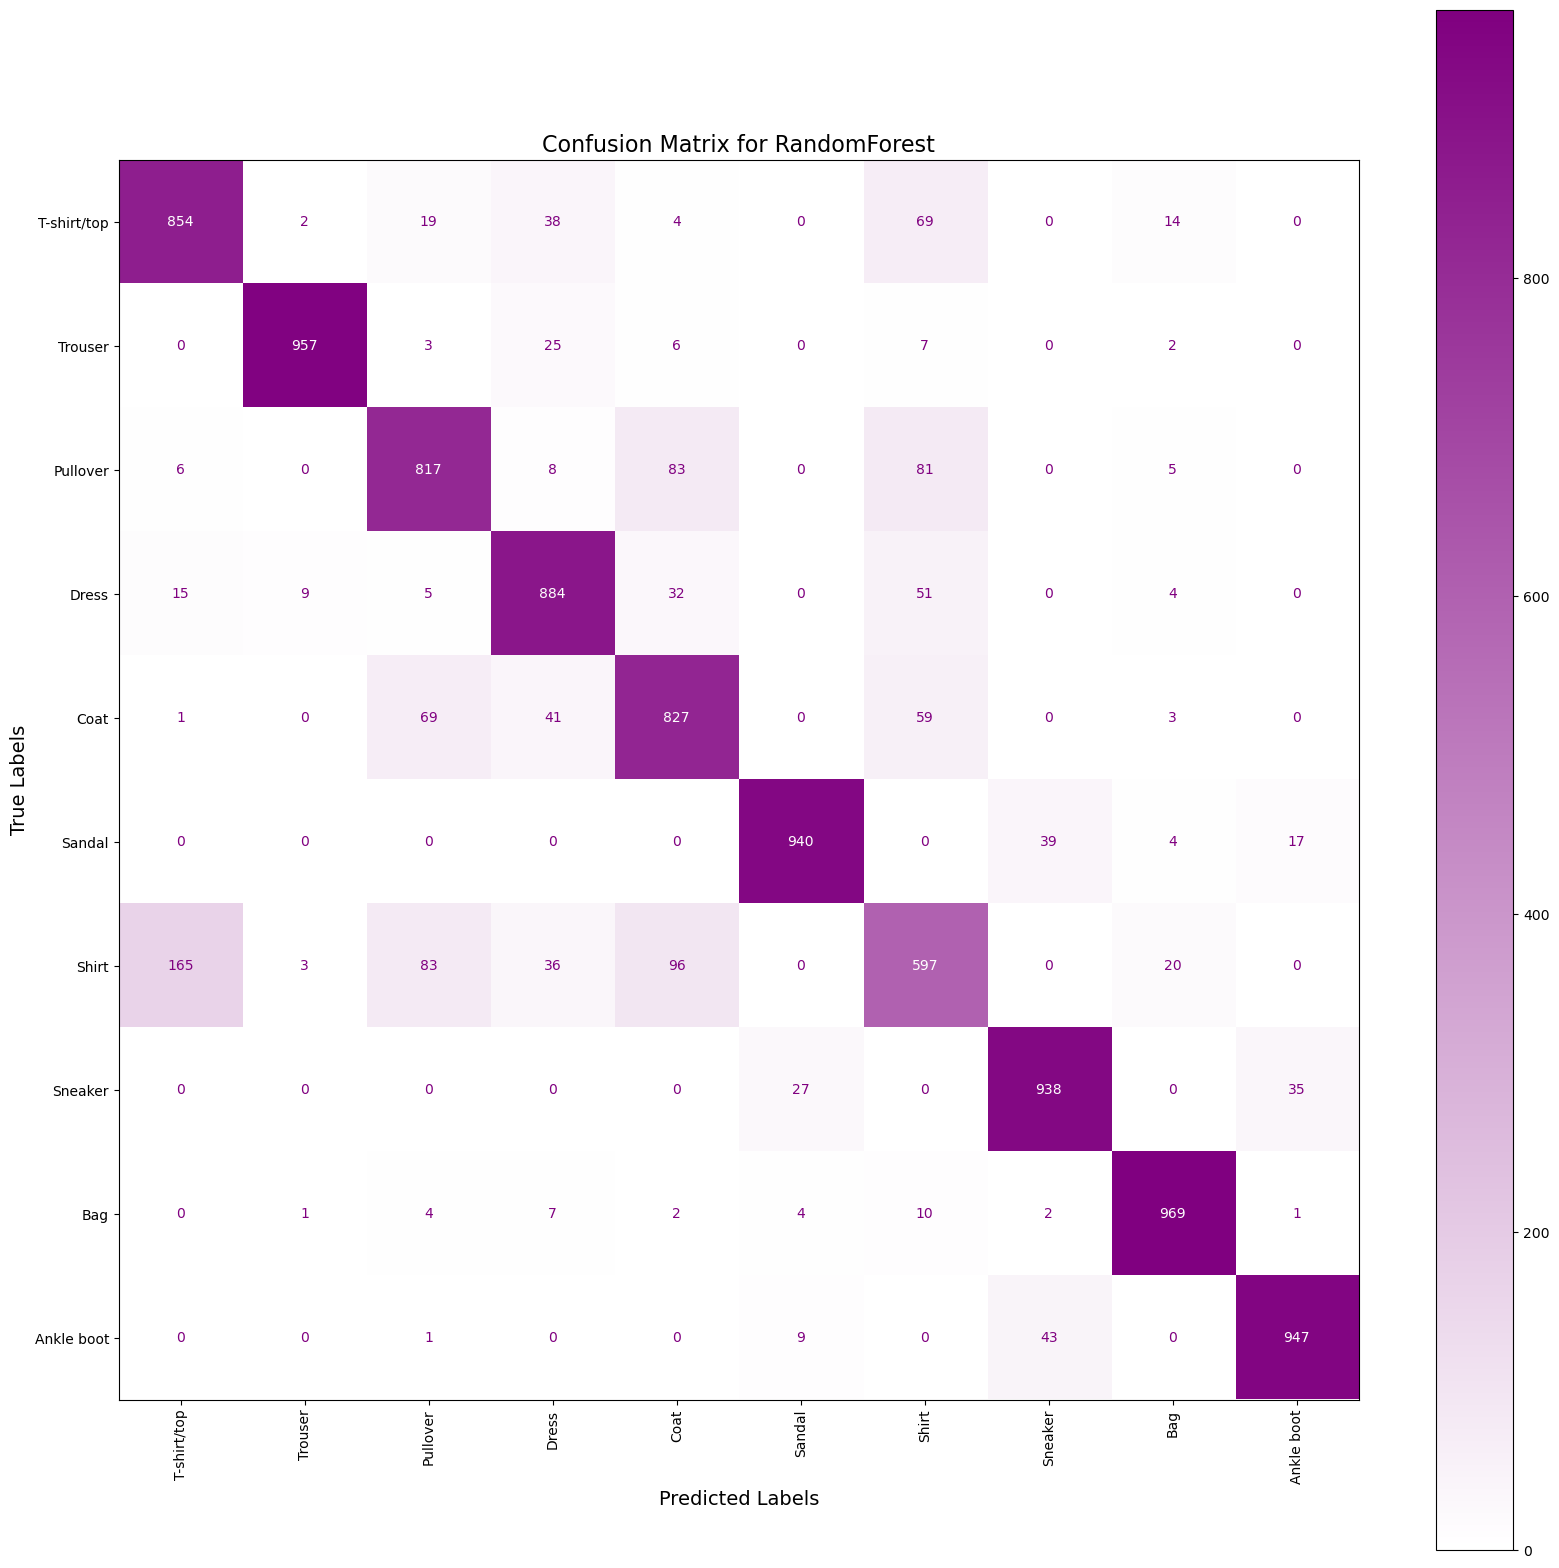

In [73]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_test_rf)

white_to_pink = mcolors.LinearSegmentedColormap.from_list("white_to_pink", ["white", "purple"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=class_names)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=white_to_pink, ax=ax, xticks_rotation='vertical')

plt.title("Confusion Matrix for RandomForest", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.show()


## 4.4.4 GradientBoosted Tree

In [76]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid_xgb, 
    cv=3, 
    scoring='accuracy', 
    verbose=2, 
    n_jobs=-1
)

In [77]:
grid_search_xgb.fit(X_train_small, y_train_small)

print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:28:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:28:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:28:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:28:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  53.6s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  54.3s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  54.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:29:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:29:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:29:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 1.4min
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 1.4min
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 1.4min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:29:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:29:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:29:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time= 1.8min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time= 1.8min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time= 1.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:30:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:30:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:30:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 2.8min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 2.8min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 2.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:32:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:32:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:32:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 3.8min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 3.8min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 3.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:32:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:32:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:32:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time= 2.4min


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time= 2.4min
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time= 2.4min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:32:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:32:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:32:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time= 1.0min
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time= 1.0min
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time= 1.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:33:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time= 5.7min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time= 5.8min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time= 5.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:35:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:35:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:35:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 2.0min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 2.0min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 2.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:35:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:35:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:35:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 4.8min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 4.8min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 4.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:36:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:36:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:36:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 1.6min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 1.6min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time= 1.6min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:37:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:37:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:37:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 3.9min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 3.9min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 3.9min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:39:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:39:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:39:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time= 3.0min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time= 3.0min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time= 3.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:39:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:39:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:39:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time= 2.4min
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time= 2.4min
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time= 2.5min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:41:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:41:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 9.8min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 9.8min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 9.9min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:42:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:42:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=3, n_estimators=50; total time= 1.0min
[CV] END ....learning_rate=0.2, max_depth=3, n_estimators=50; total time= 1.1min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 5.9min
[CV] END ....learning_rate=0.2, max_depth=3, n_estimators=50; total time= 1.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 5.9min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:43:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:43:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:43:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 6.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 4.5min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 4.5min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 4.6min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:44:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:44:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:44:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time= 1.9min
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time= 2.0min
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time= 2.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time= 1.5min
[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time= 1.5min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:46:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time= 1.5min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:46:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:46:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time= 3.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time= 3.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:46:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time= 3.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time= 2.9min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time= 3.0min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time= 3.0min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:48:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:48:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:48:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time= 2.3min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:49:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time= 2.3min
[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time= 2.3min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:49:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:49:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 8.5min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 8.4min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 8.6min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time= 5.7min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time= 5.8min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time= 5.8min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time= 3.9min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time= 3.9min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time= 3.9min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time= 5.8min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time= 5.8min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time= 5.8min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}


In [78]:
best_model_xgb = grid_search_xgb.best_estimator_

In [79]:
y_pred_val_xgb = best_model_xgb.predict(X_val)
accuracy_val_xgb = accuracy_score(y_val, y_pred_val_xgb)

print(f"Accuracy on the Validation Set: {accuracy_val_xgb}")

Accuracy on the Validation Set: 0.9043333333333333


In [80]:
y_pred_test_xgb = best_model_xgb.predict(X_test_selected)
accuracy_test_xgb = accuracy_score(y_test, y_pred_test_xgb)

print(f"Accuracy on the Test Set: {accuracy_test_xgb}")

Accuracy on the Test Set: 0.9023


### Table Report for XGBoost

In [81]:
print("Test Classification Report for XGBoost:\n", classification_report(y_test, y_pred_test_xgb, target_names=class_names))

Test Classification Report for XGBoost:
               precision    recall  f1-score   support

 T-shirt/top       0.85      0.86      0.86      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.86      0.85      0.86      1000
       Dress       0.88      0.91      0.90      1000
        Coat       0.84      0.86      0.85      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.73      0.70      0.72      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



### Confusion Matrix for XGBoost 

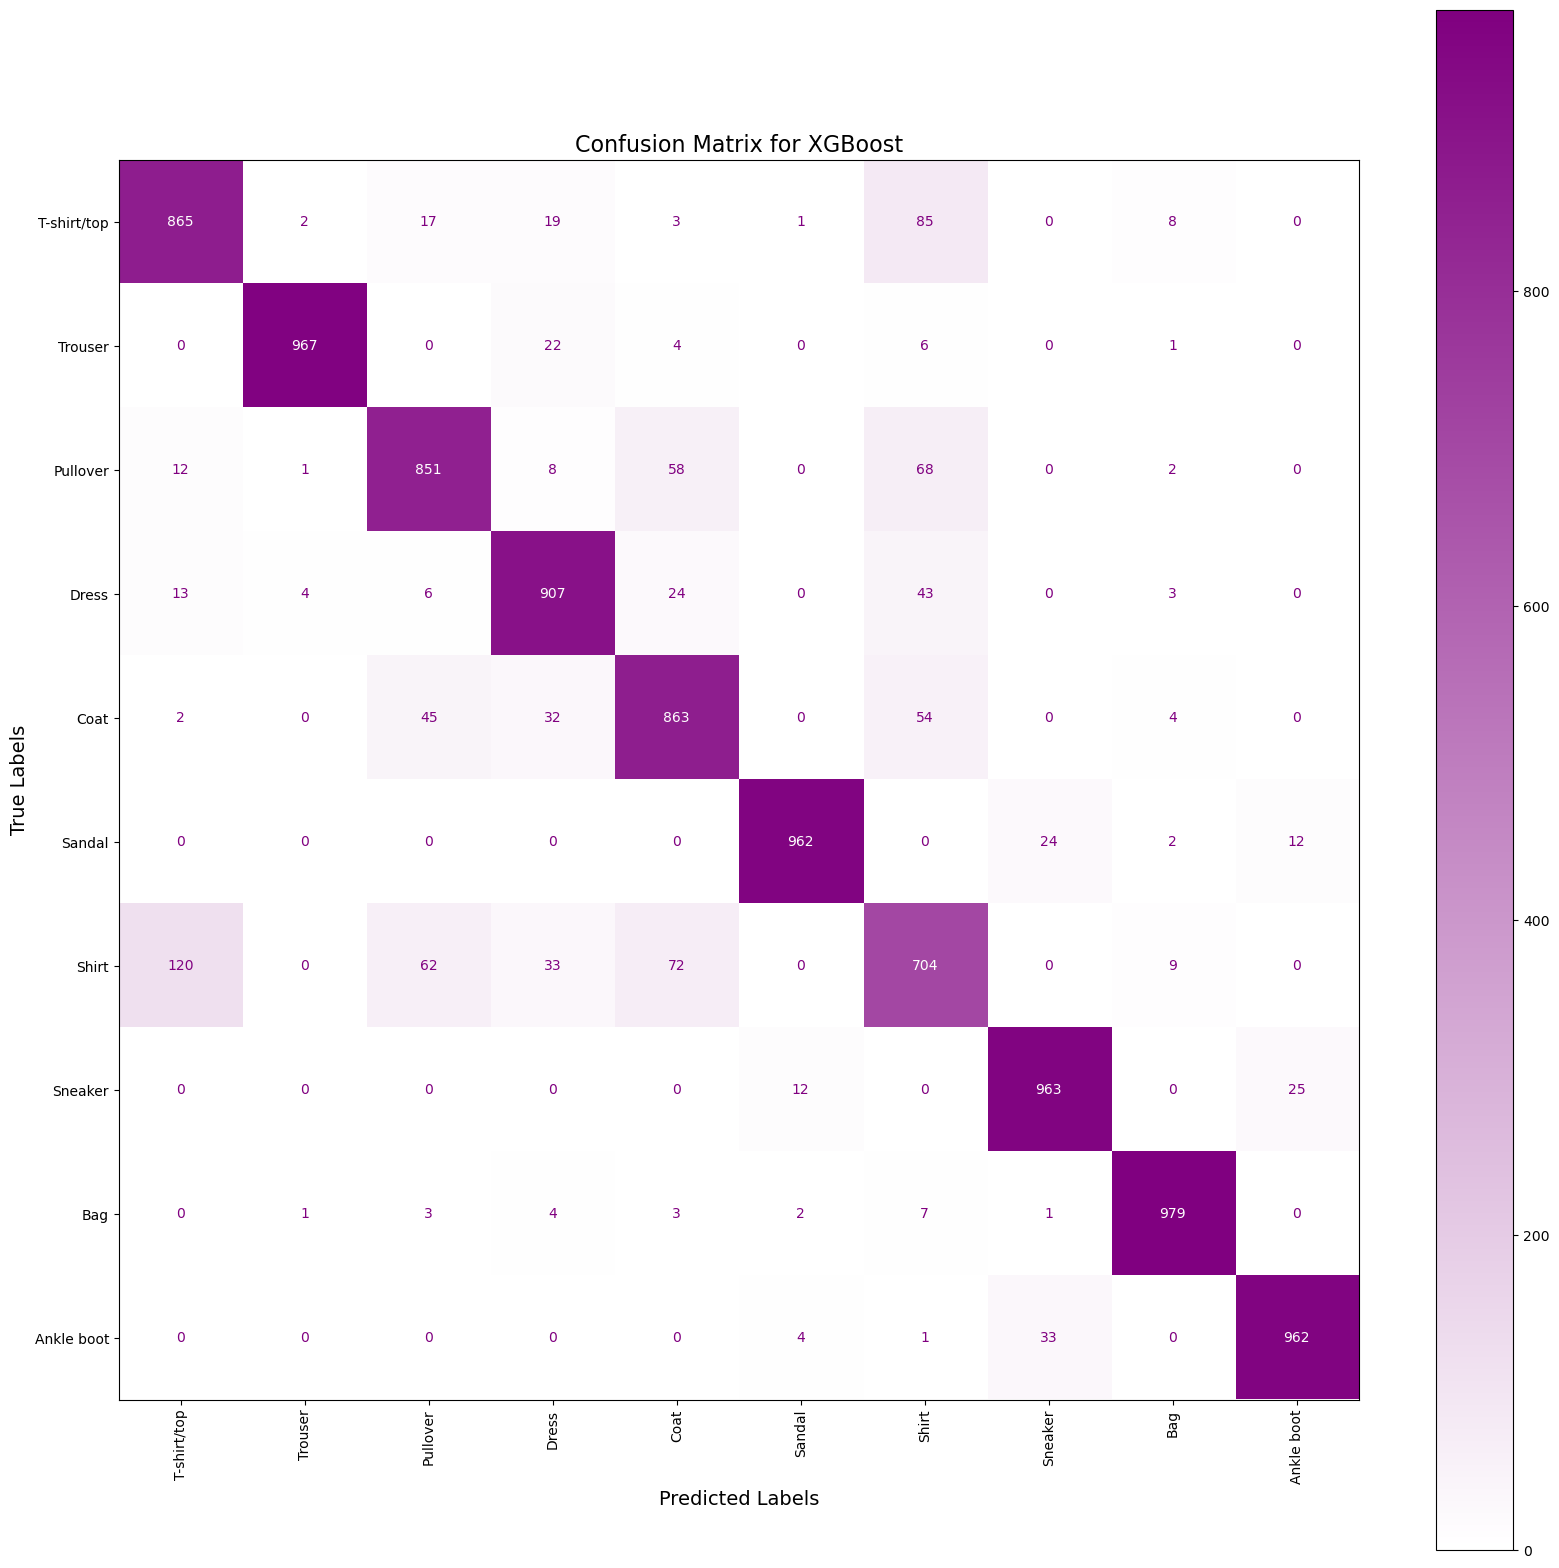

In [82]:
conf_matrix_xgb = confusion_matrix(y_test, y_pred_test_xgb)

white_to_pink = mcolors.LinearSegmentedColormap.from_list("white_to_pink", ["white", "purple"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=class_names)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=white_to_pink, ax=ax, xticks_rotation='vertical')

plt.title("Confusion Matrix for XGBoost", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.show()
